    You’ll need to get historical price data of some sort, we use yfinance (the python package). The more data the better. It’s up to you to decide what data is particularly relevant, for example, for training data, 2020 was not a simple year, so this may skew our model terribly.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from keras.models import Sequential
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import pandas as pd
import random


import warnings
warnings.filterwarnings("ignore")

    We’re pulling in:

    - We’re going to use bitcoin-EUR price data
    - Data from 2010
    - Period of data to be in daily granularity

In [2]:
##############################
### Getting the raw data #####
#############################

#Define the ticker symbol to get from, in our case we're getting apple stock
tickerSymbol = 'BTC-EUR'
tickerData = yf.Ticker(tickerSymbol)

#  Get the historical prices for this ticker.
# We pick from 2021-1-1
data = tickerData.history(interval='1d', start='2010-1-1', end='2023-1-1')
data['price'] = (data['High'] + data['Low'])/2
#data.rename(columns={'Close': 'price'}, inplace=True)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,price
Date,,,,,,,,
2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0,356.527695
2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0,337.647430
2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0,314.928864
2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0,316.954712
2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0,314.003357
...,...,...,...,...,...,...,...,...
2022-12-27 00:00:00+00:00,15902.340820,15935.183594,15632.481445,15716.216797,14805618249,0.0,0.0,15783.832520
2022-12-28 00:00:00+00:00,15715.489258,15743.266602,15546.357422,15573.189453,15999519839,0.0,0.0,15644.812012
2022-12-29 00:00:00+00:00,15572.955078,15637.797852,15534.274414,15611.149414,13575508700,0.0,0.0,15586.036133


### 2) Creating the features and position

    As with any model, we need feature columns. For this we will use four types of features:

    - Lags: lag columns are basically the previous day(s) return depending on which lag number. So one feature might be lag 1 (log returns one day before), lag 2 (price two days before) and so on. We will create 7 lag columns as features.
    - Momentum: The Rolling mean
    - Volatility: Rolling standard deviation
    - Distance
    
    We’ll also create a column called Position (AKA direction of price), which is the target column we’d want to predict. 1 indicates the price went up, and 0 for down.

In [3]:
#################################################################
################## Creating Feature Columns #####################
#################################################################

# 1) Creating dataframe with just price and date as index
df = data[['price']]

# 2) Creating a column for log returns
# ! J'ai pas compris .shift()
# ! J'ai pas compris ce qui se passe ici réellement
df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

# 3) Creating a column that shows the position of the stock, 0 if it's going down and 1 if up
# if log returns is positive, it means it went up that day
# This will be the column used to train the deep learning model
df['position'] = np.where(df['log_returns'] > 0, 1, 0) 


# 4) Creating Lag features, Lag columns are basically the previous day(s) price depending on which lag number
# e.g lags_3 means the price 3 days ago. These are features to be passed in the model, we use 5 lags here.

def lag_column_creator(df, num_lags):
    for lag_num in range(1, num_lags + 1): 
        df[f'lags_{lag_num}'] = df['log_returns'].shift(lag_num) 
        df.dropna(inplace=True) 
    return df

df = lag_column_creator(df, 7)

# 5) Addition of Exra features
# Here we add momentum, volatility and distance as more features to our model for raining
# ! Revoir ce que veux dire rolling() et shift()
df['momentum'] = df['log_returns'].rolling(5).mean().shift(1)
df['volatility'] = df['log_returns'].rolling(20).std().shift(1)
df['distance'] = (df['price'] - df['price'].rolling(50).mean()).shift(1)

#6 Dropping nulls
df.dropna(inplace=True)

df

,price,log_returns,position,lags_1,lags_2,lags_3,lags_4,lags_5,lags_6,lags_7,momentum,volatility,distance
Date,,,,,,,,,,,,,
2014-12-05 00:00:00+00:00,301.980255,-0.001086,0,-0.013160,0.000944,0.001753,0.006691,-0.005160,0.024513,0.001129,-0.001787,0.025455,8.938278
2014-12-06 00:00:00+00:00,305.003250,0.009961,1,-0.001086,-0.013160,0.000944,0.001753,0.006691,-0.005160,0.024513,-0.000972,0.023991,8.591748
2014-12-07 00:00:00+00:00,305.086548,0.000273,1,0.009961,-0.001086,-0.013160,0.000944,0.001753,0.006691,-0.005160,-0.000318,0.023909,11.464528
2014-12-08 00:00:00+00:00,299.922562,-0.017071,0,0.000273,0.009961,-0.001086,-0.013160,0.000944,0.001753,0.006691,-0.000614,0.022643,11.514363
2014-12-09 00:00:00+00:00,286.632584,-0.045323,0,-0.017071,0.000273,0.009961,-0.001086,-0.013160,0.000944,0.001753,-0.004217,0.021784,6.469320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27 00:00:00+00:00,15783.832520,-0.004794,0,0.004304,0.000944,-0.007185,0.008348,-0.006068,0.007388,0.004907,0.000068,0.012476,-380.445059
2022-12-28 00:00:00+00:00,15644.812012,-0.008847,0,-0.004794,0.004304,0.000944,-0.007185,0.008348,-0.006068,0.007388,0.000323,0.012486,-355.500713
2022-12-29 00:00:00+00:00,15586.036133,-0.003764,0,-0.008847,-0.004794,0.004304,0.000944,-0.007185,0.008348,-0.006068,-0.003116,0.012600,-426.073145


    As seen above, 10 new features: lags, momentum, volatility, and distance. The position is our target variable to predict.

    You’ll also need a list of the column feature names:    

In [4]:
###############################################################
######### Getting list of Column feature names ################
###############################################################
column_names = list(df.columns)[3:]
column_names

['lags_1',
 'lags_2',
 'lags_3',
 'lags_4',
 'lags_5',
 'lags_6',
 'lags_7',
 'momentum',
 'volatility',
 'distance']

### 3) The Model
    Here we have the training of the model. I’ve documented the steps in the comments of the code. Feel free to vary the dates and see how they affect your model.

    Just a few things to note before reading:

    - I convert the data to normal dist (line 12), this is common in ML to standardize the data.
    - I set a random seed for consistency. You should vary the seed to see how much it varies the model.
    - I use the sequential model, in which I’ve specified 3 layers. The last layer output has 1 in it, just as we only need one output. I’ve used activation = relu, which is Rectified linear unit. It’s one of the best activation functions for deep learning and is suitable for our binary output model as it outputs a 0 whenever the log returns are negative. The last layer uses sigmoid; it’s important to note that its output will be from 0 to 1 and we’ll consider > 0.5 to be a positive direction prediction.

In [6]:
########################################################
################# The Model ############################
########################################################

# 1) Segmenting the training data (doing it manually - can automate once conceptualised)
training_data = df[df.index < '2021-08-01'].copy()

# 2) Converting to normal distribution for ML z = x-mean/std
mean, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mean) / std

# 3) Segmenting and converting test data
test_data = df[df.index >= '2021-08-01'].copy()
test_data_ = (test_data - mean) / std

# 4) Setting random seed for consistency
random.seed(90)
np.random.seed(90)
tf.random.set_seed(90)

# 5) Calling the sequention deep learning model and specifying 3 layers
# Note the last layer uses sigmoid activation indicating output will be between 0 to 1
optimizer = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Dense(64, activation='relu',
              input_shape=(len(column_names),)))  
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

# 6) Fitting the model
model.fit(training_data_[column_names], training_data['position'],
        verbose=False, epochs=25)

    Let’s evaluate the accuracy of our model:

In [7]:
############# Evaluate Model's accuracy ##################
model.evaluate(training_data_[column_names], training_data['position'])

76/76 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.6216


[0.640927255153656, 0.6215549111366272]

    Accuracy of 0.622, let’s be honest, over time, an accuracy of 0.62 is pretty good for something so random! I’d rather be 62% right than 50% random guesses!

### 4) Predicting the test data

    Let’s now predict the test data. Below I predict the direction of the price of the day. 1 being up, -1 being down. Again, as I said in step 4, according to sigmoid, above 0.5 will mean up, i.e. 1 (line 7).

17/17 [==============================] - 0s 881us/step


<AxesSubplot:xlabel='Date'>

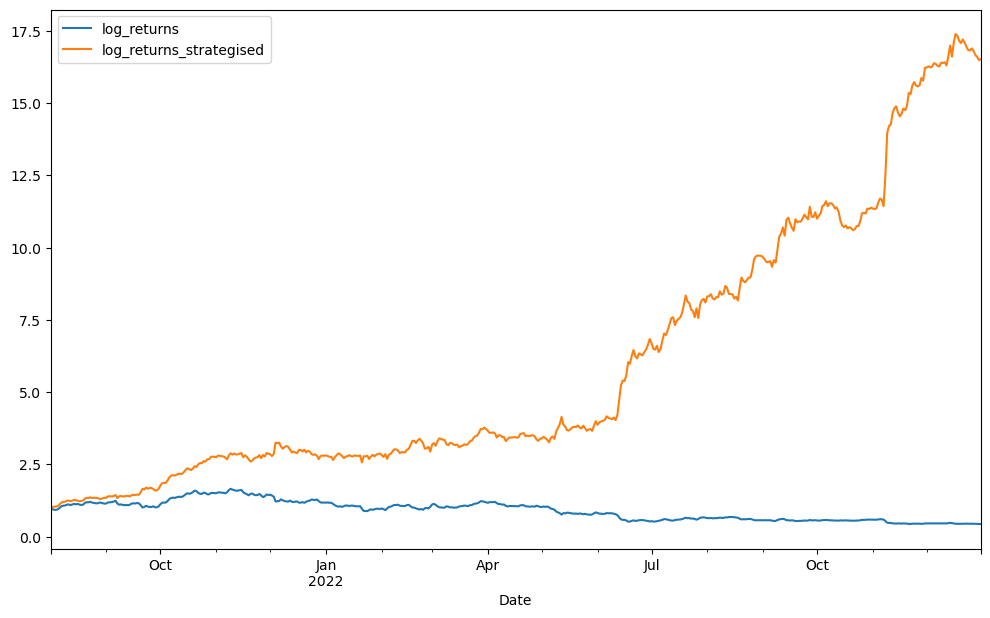

In [12]:
##################################################################
################# Predict the test data ##########################
##################################################################

# 1) Creating new column called prediction. 
# Remembering that we used sigmoid activation meaning the output that comes out is 0-1, if above .5 then round up to 1 as going up position
prediction = np.where(model.predict(test_data_[column_names]) > 0.5, 1, 0)
# Turning the prediction to 1 and -1
test_data['prediction'] = np.where(prediction > 0, 1, -1)


# 2) Creating a column called log_returns_strategised to show the estimated log returns if we followed the strategy 
# i.e. following to buy when predicted to go up, and sell when down (in an ideal world instant buying and no fees)
test_data['log_returns_strategised'] = (test_data['prediction'] * test_data['log_returns'])

# 3) Plotting the cum sum to see how effective our model would be
test_data[['log_returns', 'log_returns_strategised']].sum().apply(np.exp)
test_data[['log_returns', 'log_returns_strategised']].cumsum().apply(np.exp).plot(figsize=(12, 7))

    Note that in this particular case with bitcoin and these dates it worked out well, but not all coins/stocks behave the same. Some are too volatile, some are too dependent on external factors, and some are simply too hard to predict. Or maybe, we aren’t using the right numbers for the right time series. **So this will not work for everything!**

### Next steps — Productionising
    We cover conception in this article, but how do we get this to make us $$$$$? We’d have to productionise it. Some things to consider:

    - Tweak and build on this conception code to be suitable for your use case.
    - Create classes, functions, and modules and turn them into a python application that continually trains the model and applies daily prediction.
    - Implement a real time ticker to get the data in real time
    - Consider the use of creating a bot, that can trade for you in real time with low fees. I recommend looking into Oanda as an API for you to execute such functions.
    - Host your application on the cloud to run 24–7. If you want something super simple, look into droplet and host there. However, I recommend AWS to be your go to.